In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/MLDL-Project/Code/Codebase_inUse"

/content/drive/.shortcut-targets-by-id/1qdeOmMzRTTZYag_nMfIYW1ptaZ_OpJwD/MLDL-Project/Code/Codebase_inUse


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from FDA.fda import *
from model_t3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
args_dict = {
    'seed' : 42,
    'dataset' : 'gtaV',
    'model' : 'deeplabv3_mobilenetv2',
    'num_epochs' : 20 ,
    'n_exp' : 1,
    'print_times' : True,
    'da' : 'advanced',
    'bs' : 8,
    'nw' : 2,
    'lr': 0.1,
    'wd' : 0.0001,
    'hnm' : False,
    'opt' : 'SGD',
    'm' : 0.9,
    'policy' : 'poly',
    'lr_power' : 0.9,
    'test' : False,
    'warmup' : 0,
    'train_display_interval' : 1,
    'valid_interval' : 1,
    'n_final_epochs' : 1,
    'save_best_model' : False,
    'style_transfer' : False,
    'L' : 0.01,
    'num_images_per_style' : -1
}

args = get_parser(args_dict)

In [ ]:
#datasets
print(' Generating datasets...')
train_dataset, valid_datasets, test_datasets = get_datasets(args)
client_datasets = valid_datasets
valid_dataset = ConcatDataset(valid_datasets)
print(' ...done')

 Generating datasets...
 ...done


In [ ]:
print(" Creating the styles")
style_augment = StyleAugment(n_images_per_style = -1, L =0.00001)
for client_ds in client_datasets:
   style_augment.add_style(client_ds, name = client_ds.client_name)
print("\n Finished!")

 Creating the styles


100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


 Finished!


## CLUSTERING WITHOUT PCA

(3, 1, 1)
24
(3,)
 Time for cluster 2: 0.013348102569580078s
 Time for cluster 3: 0.011542320251464844s
 Time for cluster 4: 0.00920867919921875s
 Time for cluster 5: 0.01110982894897461s
 Time for cluster 6: 0.011716604232788086s
 Time for cluster 7: 0.012710332870483398s
 Time for cluster 8: 0.01425623893737793s
 Time for cluster 9: 0.01563405990600586s
 Time for cluster 10: 0.016828298568725586s
 Time for cluster 11: 0.018451213836669922s
 Time for cluster 12: 0.019505023956298828s
 Time for cluster 13: 0.021930932998657227s
 Time for cluster 14: 0.02696061134338379s

Best k:  5
{0: ['T01_CS_J_U1', 'T01_CS_J_U2', 'T01_CS_A_U1', 'T01_CS_A_U2'], 1: ['T02_CN_A_U1', 'T02_CN_A_U2', 'T01_CN_J_U1', 'T01_CN_J_U2', 'T01_CN_A_U1', 'T01_CN_A_U2', 'T02_CN_J_U1', 'T02_CN_J_U2'], 2: ['T03_CS_A_U1', 'T03_CS_A_U2', 'T03_CS_J_U1', 'T03_CS_J_U2'], 3: ['T03_CN_A_U1', 'T03_CN_A_U2', 'T03_CN_J_U1', 'T03_CN_J_U2'], 4: ['T02_CS_A_U1', 'T02_CS_A_U2', 'T02_CS_J_U1', 'T02_CS_J_U2']}
[[ -6508751.22162129   51

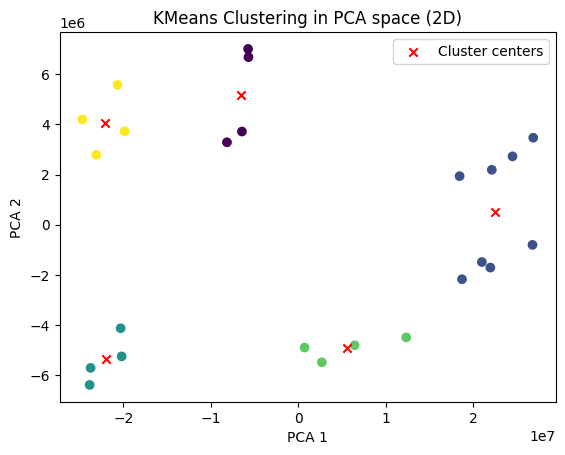

In [ ]:
#Si clustera SENZA PCA

#Retrieving both the styles and their names (client id)
styles, styles_names = style_augment.styles, style_augment.styles_names
print(styles[0].shape)
#Flatten the styles
styles_flat = np.array(styles).reshape(len(styles), -1)
print(len(styles_flat))
print(styles_flat[0].shape)
cluster_mapping = dict()
clustering_list = list()
res_list = list()
score_list = list()

#Range for k
m,n = 2,15

k_list = list(range(m,n))

#Number of iterations of KMeans(for stability)
N = 10
#For k between n and m-1
for k in k_list:
  start = time.time()
  clustering = KMeans(n_clusters = k, n_init = N).fit(styles_flat)
  end = time.time()
  print(f" Time for cluster {k}: {end-start}s")
  clustering_list.append(clustering)
  res_list.append(clustering.labels_)
  score_list.append(silhouette_score(styles_flat, clustering.labels_))
#In the above loop we do, for each k, N iterations. Among the N iterations we take the best cluster in terms of intra cluster distance.

#Taking the index of the best clustering between the n - (m - 1)  according to the silhouette score.
best_id = np.argmax(score_list)
#Selecting the best clustering
best_clustering = clustering_list[best_id]
#Selecting the k associated to the best clustering
best_k = k_list[best_id]
#This loop goes through each
#cluster in the best model and maps the cluster id to the style id for all styles in that cluster.
for cluster_id in range(best_k):
  cluster_mapping[cluster_id] = [styles_names[i] for i,cluster_label in enumerate(res_list[best_id]) if cluster_label == cluster_id]

print("\nBest k: ",best_k)
print(cluster_mapping)

pca = PCA(n_components = 2)
data_2d = pca.fit_transform(styles_flat)
cluster_centers_2d = pca.transform(best_clustering.cluster_centers_)


print(cluster_centers_2d)


pca = PCA(n_components=2)
styles_pca = pca.fit_transform(styles_flat)
pca_cluster_centers = pca.transform(best_clustering.cluster_centers_)

plt.scatter(styles_pca[:, 0], styles_pca[:, 1], c=best_clustering.labels_, cmap='viridis')
plt.scatter(pca_cluster_centers[:, 0], pca_cluster_centers[:, 1], marker='x', color='red', label='Cluster centers')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clustering in PCA space (2D)')
plt.legend()
plt.show()

In [ ]:
"""
for i in random.sample(range(len(test_datasets[1])), 10):
  print(i)
  image = test_datasets[1][i][0]
  style = style_augment._extract_style(image)
  style = style.reshape(-1)
  distances = best_clustering.transform([style])
  distances = np.divide(distances, np.sum(distances))
  print(distances)
"""


for i in range(len(styles)):
  style = styles[i]
  style = style.reshape(-1)
  distances = best_clustering.transform([style])
  distances = np.divide(distances, np.sum(distances))
  print(distances)

[[0.2082059  0.03401532 0.30956114 0.14285796 0.30535967]]
[[0.20853282 0.01537513 0.32446871 0.1307459  0.32087744]]
[[0.17599434 0.44132205 0.0191751  0.26342517 0.10008334]]
[[0.18919257 0.42584835 0.01927272 0.26721579 0.09847057]]
[[0.212142   0.02168445 0.32292106 0.11902494 0.32422756]]
[[0.20778138 0.03816041 0.32221364 0.1069066  0.32493797]]
[[0.02036501 0.36771636 0.22752072 0.18633477 0.19806314]]
[[0.03217595 0.38653401 0.20502675 0.20029686 0.17596643]]
[[0.176202   0.18317246 0.30676274 0.01125508 0.32260773]]
[[0.19359536 0.10472485 0.31411079 0.06274468 0.32482433]]
[[0.16617483 0.43088336 0.09114404 0.28736963 0.02442814]]
[[0.14381367 0.43819992 0.11226673 0.284664   0.02105568]]
[[0.17296718 0.44756522 0.02241868 0.2685862  0.08846272]]
[[0.18841863 0.43155392 0.01642911 0.27071576 0.09288258]]
[[0.19993826 0.03477945 0.32668344 0.11603371 0.32256514]]
[[0.20966974 0.02013748 0.31827922 0.1377159  0.31419766]]
[[0.2140993  0.01722265 0.32225533 0.12228283 0.32413989

## CLUSTERING WITH PCA

(3, 1, 1)
 Time for cluster 2: 0.008455753326416016s
 Time for cluster 3: 0.007080078125s
 Time for cluster 4: 0.008298158645629883s
 Time for cluster 5: 0.010248422622680664s
 Time for cluster 6: 0.01163172721862793s
 Time for cluster 7: 0.01272892951965332s
 Time for cluster 8: 0.016592979431152344s
 Time for cluster 9: 0.015363454818725586s
 Time for cluster 10: 0.025415897369384766s
 Time for cluster 11: 0.018299102783203125s
 Time for cluster 12: 0.021142005920410156s
 Time for cluster 13: 0.02149486541748047s
 Time for cluster 14: 0.03532862663269043s

Best k:  5
{0: ['T01_CS_J_U1', 'T01_CS_J_U2', 'T01_CS_A_U1', 'T01_CS_A_U2'], 1: ['T02_CN_A_U1', 'T02_CN_A_U2', 'T01_CN_J_U1', 'T01_CN_J_U2', 'T01_CN_A_U1', 'T01_CN_A_U2', 'T02_CN_J_U1', 'T02_CN_J_U2'], 2: ['T03_CS_A_U1', 'T03_CS_A_U2', 'T03_CS_J_U1', 'T03_CS_J_U2'], 3: ['T03_CN_A_U1', 'T03_CN_A_U2', 'T03_CN_J_U1', 'T03_CN_J_U2'], 4: ['T02_CS_A_U1', 'T02_CS_A_U2', 'T02_CS_J_U1', 'T02_CS_J_U2']}


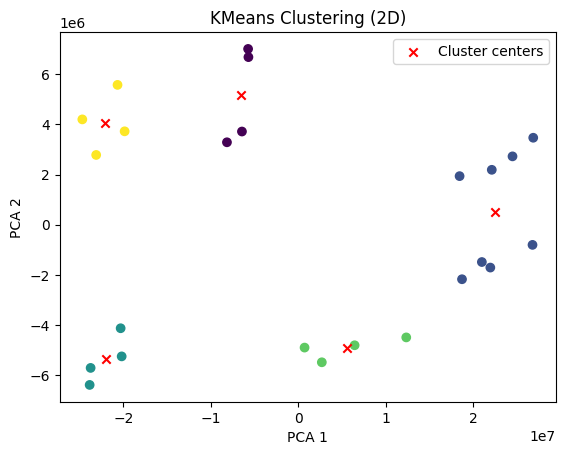

In [ ]:
#Si clustera con PCA

#Retrieving both the styles and their names (client id)
styles, styles_names = style_augment.styles, style_augment.styles_names
print(styles[0].shape)
#Flatten the styles
styles_flat = np.array(styles).reshape(len(styles), -1)


#PCA
pca = PCA(n_components=2)
styles_pca = pca.fit_transform(styles_flat)


cluster_mapping = dict()
clustering_list = list()
res_list = list()
score_list = list()

#Range for k
m,n = 2,15

k_list = list(range(m,n))

#Number of iterations of KMeans(for stability)
N = 10
#For k between n and m-1
for k in k_list:
  start = time.time()
  clustering = KMeans(n_clusters = k, n_init = N).fit(styles_pca)
  end = time.time()
  print(f" Time for cluster {k}: {end-start}s")
  clustering_list.append(clustering)
  res_list.append(clustering.labels_)
  score_list.append(silhouette_score(styles_pca, clustering.labels_))
#In the above loop we do, for each k, N iterations. Among the N iterations we take the best cluster in terms of intra cluster distance.

#Taking the index of the best clustering between the n - (m - 1)  according to the silhouette score.
best_id = np.argmax(score_list)
#Selecting the best clustering
best_clustering = clustering_list[best_id]
#Selecting the k associated to the best clustering
best_k = k_list[best_id]
#This loop goes through each
#cluster in the best model and maps the cluster id to the style id for all styles in that cluster.
for cluster_id in range(best_k):
  cluster_mapping[cluster_id] = [styles_names[i] for i,cluster_label in enumerate(res_list[best_id]) if cluster_label == cluster_id]

print("\nBest k: ",best_k)
print(cluster_mapping)

plt.scatter(styles_pca[:, 0], styles_pca[:, 1], c=best_clustering.labels_, cmap='viridis')
cluster_centers = best_clustering.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', label='Cluster centers')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clustering (2D)')
plt.legend()
plt.show()

In [ ]:
for i in random.sample(range(len(test_datasets[1])), 10):
  print(i)
  image = test_datasets[1][i][0]
  style = style_augment._extract_style(image)
  style = style.reshape(-1)
  style = pca.transform([style])
  distances = best_clustering.transform(style)
  distances = np.divide(distances, np.sum(distances))
  print(distances)





3
[[0.14326307 0.27916553 0.2251542  0.19849601 0.15392119]]
9
[[0.14326316 0.27916541 0.22515415 0.19849602 0.15392127]]
26
[[0.14326306 0.27916556 0.22515422 0.198496   0.15392116]]
28
[[0.14326314 0.27916544 0.22515417 0.19849601 0.15392124]]
16
[[0.14326316 0.27916541 0.22515416 0.19849601 0.15392126]]
6
[[0.14326315 0.27916543 0.22515417 0.19849601 0.15392125]]
21
[[0.14326308 0.27916552 0.2251542  0.19849601 0.15392119]]
18
[[0.14326318 0.27916538 0.22515415 0.19849601 0.15392127]]
109
[[0.14326305 0.27916554 0.22515419 0.19849602 0.1539212 ]]
98
[[0.14326318 0.27916538 0.22515416 0.19849601 0.15392127]]


## TSNE

In [ ]:
# With t-SNE
from sklearn.manifold import TSNE

#Retrieving both the styles and their names (client id)
styles, styles_names = style_augment.styles, style_augment.styles_names
print(styles[0].shape)
#Flatten the styles
styles_flat = np.array(styles).reshape(len(styles), -1)
print(len(styles_flat[0]))
cluster_mapping = dict()
clustering_list = list()
res_list = list()
score_list = list()

#Range for k
m,n = 2,15

k_list = list(range(m,n))

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
projected_styles = tsne.fit_transform(styles_flat)

#Number of iterations of KMeans(for stability)
N = 10
#For k between n and m-1
for k in k_list:
  start = time.time()
  clustering = KMeans(n_clusters = k, n_init = N).fit(projected_styles)
  end = time.time()
  print(f" Time for cluster {k}: {end-start}s")
  clustering_list.append(clustering)
  res_list.append(clustering.labels_)
  score_list.append(silhouette_score(styles_flat, clustering.labels_))
#In the above loop we do, for each k, N iterations. Among the N iterations we take the best cluster in terms of intra cluster distance.

#Taking the index of the best clustering between the n - (m - 1)  according to the silhouette score.
best_id = np.argmax(score_list)
#Selecting the best clustering
best_clustering = clustering_list[best_id]
#Selecting the k associated to the best clustering
best_k = k_list[best_id]
#This loop goes through each
#cluster in the best model and maps the cluster id to the style id for all styles in that cluster.
for cluster_id in range(best_k):
  cluster_mapping[cluster_id] = [styles_names[i] for i,cluster_label in enumerate(res_list[best_id]) if cluster_label == cluster_id]

print("\nBest k: ",best_k)
print(cluster_mapping)


(3, 11, 11)
363
 Time for cluster 2: 0.010630607604980469s
 Time for cluster 3: 0.014216423034667969s
 Time for cluster 4: 0.030733585357666016s
 Time for cluster 5: 0.03522634506225586s
 Time for cluster 6: 0.01739811897277832s
 Time for cluster 7: 0.022045373916625977s
 Time for cluster 8: 0.11499595642089844s
 Time for cluster 9: 0.12331414222717285s
 Time for cluster 10: 0.09222173690795898s
 Time for cluster 11: 0.06197023391723633s
 Time for cluster 12: 0.04208040237426758s
 Time for cluster 13: 0.30103349685668945s
 Time for cluster 14: 0.1699202060699463s

Best k:  5
{0: ['T01_CS_J_U1', 'T01_CS_J_U2', 'T01_CS_A_U1', 'T01_CS_A_U2'], 1: ['T02_CN_A_U1', 'T02_CN_A_U2', 'T01_CN_J_U1', 'T01_CN_J_U2', 'T01_CN_A_U1', 'T01_CN_A_U2', 'T02_CN_J_U1', 'T02_CN_J_U2'], 2: ['T03_CN_A_U1', 'T03_CN_A_U2', 'T03_CN_J_U1', 'T03_CN_J_U2'], 3: ['T03_CS_A_U1', 'T03_CS_A_U2', 'T03_CS_J_U1', 'T03_CS_J_U2'], 4: ['T02_CS_A_U1', 'T02_CS_A_U2', 'T02_CS_J_U1', 'T02_CS_J_U2']}


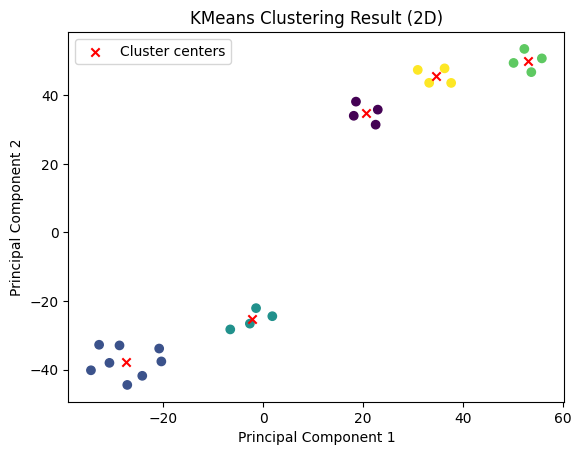

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

cluster_centers_2d = best_clustering.cluster_centers_


# Scatter plot of data points with color-coded clusters
plt.scatter(projected_styles[:, 0], projected_styles[:, 1], c= best_clustering.labels_, cmap='viridis')
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], marker='x', color='red', label='Cluster centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Result (2D)')
plt.legend()
plt.show()

In [ ]:
x_range = (-40, 60)
y_range = (-50, 60)
#array = np.random.uniform(low=[x_range[0], y_range[0]], high=[x_range[1], y_range[1]])
array = np.array([20, 40])
distances = best_clustering.transform(array.reshape(1, -1))
norm_dist = distances/np.sum(distances)
similarities = 1/(1+distances)
norm_sim = similarities/np.sum(similarities)
weighted_sim = np.power(similarities, 2)  # Apply exponential function to the similarities
weighted_sim /= np.sum(weighted_sim)
weighted_sim2 = np.power(similarities, 3)  # Apply exponential function to the similarities
weighted_sim2 /= np.sum(weighted_sim2)

print(array)
print(distances)
print(norm_dist)
print(similarities)
print(norm_sim)
print("\n")
print(weighted_sim)
print(weighted_sim2)
print(np.sum(weighted_sim2))

[20 40]
[[ 5.17655157 91.0333385  69.00471902 34.498245   15.58982672]]
[[0.02404314 0.42281563 0.32050097 0.16023138 0.07240888]]
[[0.16190264 0.01086563 0.01428475 0.02817041 0.06027791]]
[[0.58766554 0.03943947 0.05185003 0.10225144 0.21879352]]


[[0.84661268 0.00381317 0.00659056 0.02563086 0.11735273]]
[[9.45300869e-01 2.85741121e-04 6.49271475e-04 4.97952166e-03
  4.87845972e-02]]
0.9999999999999998
